
## Project 7 - Email Spam Classification

### Project Objectives

- Feature engineering
- Using sklearn to build simple and more complex linear models
- Identifying informative variables through EDA
- Classification using logistic regression
- Classification metrics

## Setup Notebook

In [2]:
# Import 3rd party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import local libraries
from threshold_prediction_plot import threshold_prediction_plot, sigmoid

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Overview

Have you ever wondered how Google intercepts all of those spam emails so they don't end up in your inbox? In this project, you will build a model to classify emails as `spam` or `not-spam`. 

# The Data
The data can be found in the file `emails.csv` in the root director. The `csv` contains the following columns.

Columns of `emails.csv` include:
- `id`: An identifier for the training example
- `subject`: The subject of the email
- `email`:  The text of the email
- `label`: 1 if the email is `spam`, 0 if the email is `not-spam`

The file `emails.csv` contains 7513 rows where each row is an email.

First, import `emails.csv` to a DataFrame.

In [4]:
email_data = pd.read_csv('emails.csv', index_col=0)
email_data.head()

,id,subject,email,label
4282,4282,Subject: RE: [ILUG] Dell GX260 V Redhat 7.3\r\n,> When I get a box I don't want any of that in...,0
6293,6293,Subject: IBM eNews: Aktuelle Informationen von...,IBM eNews\r\n 4. Juli 2002\r\n \r\n Liebe Lese...,0
2349,2349,"Subject: [zzzzteana] Height, weight, girth, et...","http://www.guardian.co.uk/uk_news/story/0,3604...",0
3786,3786,Subject: Re: The GOv gets tough on Net Users.....,Hire a really talented skywriter to doodle nud...,0
4731,4731,Subject: Lander risks missing Mars trip\r\n,"URL: http://www.newsisfree.com/click/-4,805285...",0


# Data Cleaning and Pre-processing
First, convert the email and subject text to lower case. This is based on the assumption that what differentiates `spam` emails from `not-spam` emails is case-insensitive.

In [8]:
email_data['subject'] = email_data['subject'].str.lower()
email_data['email'] = email_data['email'].str.lower()

Next, let's check if our data contains any missing values. 

In [10]:
print('Missingness before imputation:')
print(email_data.isnull().sum())

Missingness before imputation:
id         0
subject    6
email      0
label      0
dtype: int64


We can see there are 6 missing values for `'subject'`. This means that a subject was not included in the email and therefore, we can we replace missing values with appropriate filler values (i.e., NaN values in the subject or email columns will be replaced with empty strings `''`). Note that while there are no missing values in the `'label'` column, we should be careful when replacing missing value labels. Doing so without consideration may introduce significant bias into our model when fitting.

In [12]:
email_data[['subject', 'email']] = email_data[['subject', 'email']].fillna('')
print('Missingness after imputation:')
print(email_data.isnull().sum())

Missingness after imputation:
id         0
subject    0
email      0
label      0
dtype: int64


Lastly, let's split `email_data` into training and validation datasets. We'll need this validation data to assess the performance of our classifier once we are finished training. Note that we have set the seed (random_state) to `0`. This will produce a pseudo-random sequence of random numbers that is the same for everyone. Do not modify this in the following questions.

You'll notice that we've added an argument for `'stratify'` and set it equal to our training target `'label'`. This is done to maintain the proportion of each class in `train` and `val`. If 20% of the emails are `spam` in the dataset, then we want 20% of the emails in the `train` and `val` datasets to be also be `spam`.

In [14]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(email_data, test_size=0.1, random_state=0, stratify=email_data['label'])
print('Train:', train.shape, 'Test:', val.shape)
print('Train spam proportion: {:.2f} %'.format(train['label'][train['label'] == 1].shape[0] / train.shape[0] * 100))
print('Test spam proportion: {:.2f} %'.format(val['label'][val['label'] == 1].shape[0] / val.shape[0] * 100))

Train: (6761, 4) Test: (752, 4)
Train spam proportion: 25.63 %
Test spam proportion: 25.66 %


# 1. Feature Engineering
We would like to take the text of an email and predict whether the email is `spam` or `not-spam`. This is a classification problem and we will be using logistic regression to train a classifier. Recall that to train a logistic regression model, we need an `nD` numeric feature array `X` and a `1D` array of corresponding binary labels `y`. Unfortunately, our data are text, not numbers. Therefore, we will need to extract some numeric features from the raw email text. Each row of `X` is an email and each column of `X` contains one feature for all the emails. We'll guide you through creating a simple feature. 

## Question 1a
In the cell below, we have printed the text of the `'email'` column for a `not-spam` and a `spam` email in the training set.

In [16]:
index = 1  # You can change this to see other examples
not_spam = train.loc[train['label'] == 0, 'email'].iloc[index]
spam = train.loc[train['label'] == 1, 'email'].iloc[index]
print('\n--------\nNOT SPAM\n--------')
print(not_spam)
print('\n----\nSPAM\n----')
print(spam)


--------
NOT SPAM
--------
url: http://diveintomark.org/archives/2002/10/05.html#perl_programmers_are_so_cute
 date: 2002-10-05t21:33:22-05:00
 
 _ian hickson_: #include web-log.txt[1]. &#8220;i used some of perl's niftier 
 features, such as using method lookup instead of a switch statement for the 
 preprocessing instruction dispatching, and exceptions instead of passing error 
 codes back and forth.&#8221; he he. perl programmers are so cute when they 
 imitate python programmers.
 
 
 
 [1] http://ln.hixie.ch/?start=1033841933&count=1
 
 


----
SPAM
----
this is a multi-part message in mime format.
 
 ------=_nextpart_000_c16f3_01c260c3.2978b160
 content-type: text/plain;
 	charset="windows-1252"
 content-transfer-encoding: quoted-printable
 
  an additional income stream
  from your current book of business!
   =09
  	  	 	 =09
  	 agent commission:
 $92,000=20
  client:
  87-year-old male
  82-year-old female
 
  result:
  $2,300,000 second to die
  policy, minimal cash value. 

Discuss one thing you notice that is different between `spam` emails and `not-spam` emails that might help with the identification of `spam`.

The content of the spam emails usually is relating to money/financial information or some sort of deal. As well, the spam emails have a large amount of embedded images and HTML tags used to embed content, unlike non-spam emails.

## Question 1b
Create a function called `word_detector` that takes in a list of words and a pandas Series of email texts. It should output a DataFrame containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does.

The following code
```python 
word_detector(['hello', 'bye', 'world'], 
              pd.Series(['hello', 'hello worldhello']))
```
should output the following DataFrame.
<br>
<img src="images/q1b.png" alt="drawing" width="150"/>
<br>

In [23]:
def word_detector(words, texts):
    
    """
    Returns a DataFrame with detections of words.

    Parameters:
        words (list): A list of words to look for.
        texts (Series): A series of strings to search in.

    Returns:
        (DataFrame): A DataFrame with len(words) columns and texts.shape[0] rows.
    """
    
    #An empty dataframe is initiatd with columns for each word. Str contains is used to populate the dataframe
    #for the passed texts.
    
    df = pd.DataFrame(columns=words)
    for i in df:
        df[i] = texts.str.contains(i).astype(int)
                                         
    return df

Let's check it out.

In [25]:
word_detector(['hello', 'bye', 'world'], 
              pd.Series(['hello', 'hello worldhello']))

,hello,bye,world
0,1,0,0
1,1,0,1


And, we can check if it works for our `'email'` column in `train`.

In [27]:
word_detector(['hello', 'bye', 'world'], train['email']).head()

,hello,bye,world
6277,0,0,0
2342,0,0,0
3147,0,0,0
643,0,0,0
7128,0,0,0


It is important that the index values output from `word_detector()` match with the indices in `train`. Let's check quickly.

In [29]:
train.head()

,id,subject,email,label
6277,6277,subject: [spambayes] maybe change x-spam-dispo...,"\r\n >> accordingly, i wrote unheader.py, ...",0
2342,2342,subject: perl programmers are so cute\r\n,url: http://diveintomark.org/archives/2002/10/...,0
3147,3147,subject: sun\r\n,"well, it looks like sun are going ahead with\r...",0
643,643,subject: [spambayes] spambayes package?\r\n,\r\n >> before we get too far down this ro...,0
7128,7128,subject: re: use of base image / delta image f...,> ben mord said:\r\n > \r\n > >ah. in that cas...,0


## Question 1c
We need to identify some features that allow us to distinguish `spam` emails from `not-spam` emails. One idea is to compare the distribution of a single feature in `spam` emails to the distribution of the same feature in `not-spam` emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of `spam` emails with the word to the proportion of `not-spam` emails with the word.

The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words.
```python
words = ['body', 'business', 'html', 'money', 'offer', 'please']
```
<br>
<img src="images/q1c.png" alt="drawing" width="500"/>
<br>

Create a bar chart like the one above comparing the proportion of `spam` and `not-spam` emails containing certain words. Choose a set of **six** words that are different from the ones above, but also have different proportions for the two classes. We'll help you get started.

First let's create a list of the words we're interested in.

In [31]:
words = ['body', 'business', 'html', 'money', 'offer', 'please']

Next, let's use our function `word_detector()` to detect the words in `words`.

In [33]:
df_q1c = pd.concat((word_detector(words, train['email']), 
                    train[['label']]), axis=1)
df_q1c.head()

,body,business,html,money,offer,please,label
6277,0,0,0,0,0,1,0
2342,0,0,1,0,0,0,0
3147,0,1,0,0,0,0,0
643,0,0,0,0,0,0,0
7128,0,0,0,0,0,0,0


use the `.melt()` method to "unpivot" the DataFrame `df_q1c`.

In [35]:
df_q1c = df_q1c.melt('label')
df_q1c.head(10)

,label,variable,value
0,0,body,0
1,0,body,0
2,0,body,0
3,0,body,0
4,0,body,0
5,1,body,0
6,0,body,0
7,0,body,0
8,0,body,0
9,0,body,0


In [37]:
# New words are chosen
new_words = ['lottery', 'now', 'lose', 'opportunity', 'send', 'vacation']

# Word detector is used on train emails.
df_q1c_new = pd.concat((word_detector(new_words, train['email']), 
                    train[['label']]), axis=1)

# Melt is used to un-pivot data.
df_q1c_new = df_q1c_new.melt('label')

# Value is multipled by 100 to express as percentage
df_q1c_new['value'] = df_q1c_new['value'] * 100 

df_q1c_new.head(10)

,label,variable,value
0,0,lottery,0
1,0,lottery,0
2,0,lottery,0
3,0,lottery,0
4,0,lottery,0
5,1,lottery,0
6,0,lottery,0
7,0,lottery,0
8,0,lottery,0
9,0,lottery,0


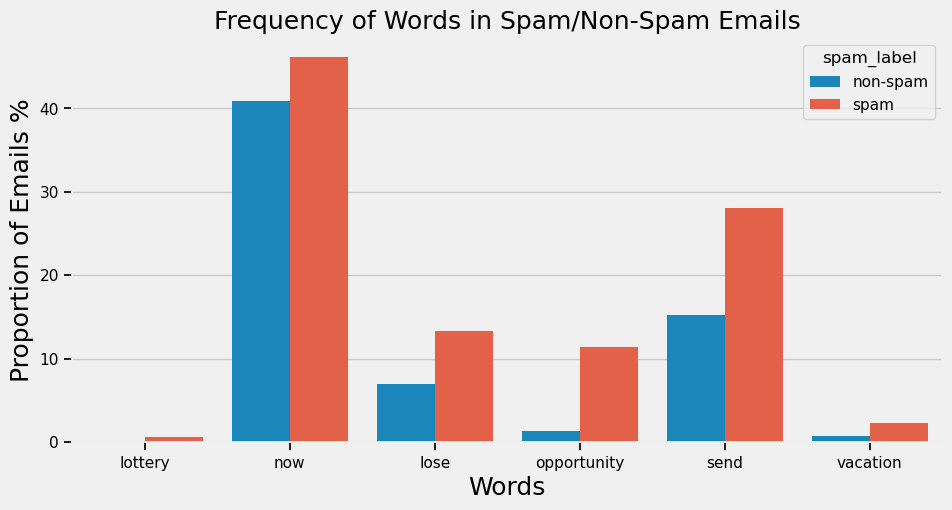

In [39]:
#add a column for spam label in the legend
df_q1c_new['spam_label'] = np.where(df_q1c_new['label'] == 0, 'non-spam', 'spam')

#sns barplot is used to show the spam/non-spam proportion for the new words
plt.figure(figsize=(10, 5))
plt.title('Frequency of Words in Spam/Non-Spam Emails', fontsize=18)
ax = sns.barplot(x="variable", y='value', hue="spam_label", data=df_q1c_new, ci=None)
ax.set_xlabel('Words', fontsize=18)
ax.set_ylabel('Proportion of Emails %', fontsize=18)
plt.show()

You can text your code with these words as a quick sanity check.
```python
words = ['body', 'business', 'html', 'money', 'offer', 'please']
```

# 2. Model Building
Our new function `word_detector(['hello', 'bye', 'world'], train['email'])` outputs a numeric DataFrame containing features for each email. This means we can use it as input to train a classifier.

## Question 2a
Let's consider 5 words that might be useful as features to distinguish `spam` from `not-spam` emails. 
```python
words = ['drug', 'bank', 'prescription', 'memo', 'private']
```
Use `words` as well as the `train` DataFrame to create two DataFrames: `X_train` and `y_train`.

`X_train` should be a DataFrame of 0s and 1s created by using `word_detector()` on all the emails in `train`.

`y_train` should be a 1D DataFrame of the correct labels for each email in `train`.

In [41]:
words = ['drug', 'bank', 'prescription', 'memo', 'private']

# X_train and y_train are defined using word_detector on the words
X_train = word_detector(words, train['email'])
y_train = train[['label']]

Check `X_train`

In [43]:
X_train.head()

,drug,bank,prescription,memo,private
6277,0,0,0,0,0
2342,0,0,0,0,0
3147,0,1,0,0,0
643,0,0,0,0,0
7128,0,0,0,0,0


and check y_train.

In [45]:
y_train.head()

,label
6277,0
2342,0
3147,0
643,0
7128,0


## Question 2b
Now that we have `X_train` and `y_train`, we can build a model with `scikit-learn`. Using the `LogisticRegression()` classifier, train a logistic regression model using `X_train` and `y_train`. Then, output the model's training accuracy below. You should get an accuracy of around `0.75`. 

You must also create a function `accuracy()` that takes two 1D numpy arrays (`y_true` and `y_pred`) and outputs an accuracy score. `y_true` and `y_pred` arrays can only contain **0**'s `not-spam` or **1**'s `spam`.

Do **NOT** use the `sklearn` function `accuracy_score()` from `sklearn.metrics` to compute the accuracy.

Hint: ```np.equal(y_true, y_pred)```

In [47]:
def accuracy(y_true, y_pred):
    
    """
    Returns a accuracy score for two 1D numpy array of the same length.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels 
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels 
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (float): Accuracy score of y_true and y_pred.
    """
    # Score compares the values in y_pred and y_true
    score = np.equal(y_true,y_pred)
    
    # Calculate the accuracy from the score
    value = np.sum(score) / len(score)
    
    return value

In [49]:
from sklearn.linear_model import LogisticRegression

# A Logistic Regression model is initiated and fitted to train data
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)

# y_true and y_pred are defined
y_true = y_train.values.flatten()
y_pred = model.predict(X_train)

# Accuracy calculation
training_accuracy = accuracy(y_true, y_pred)

# Print training accuracy
print('Training Accuracy: {:.3f}'.format(training_accuracy))

Training Accuracy: 0.757


Whoa! 75% accuracy isn't bad considering we're only using a few simple features. But wait, isn't this dataset imbalanced?

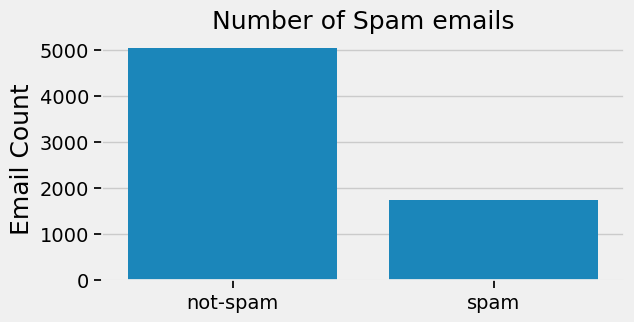

In [51]:
df_temp = train['label'].map(lambda val: 'spam' if 
                             val == 1 else 'not-spam').to_frame()

plt.figure(figsize=(6, 3))
plt.title('Number of Spam emails', fontsize=18)
ax = sns.countplot(x='label', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Email Count', fontsize=18)
plt.show()

Yes, this dataset is clearly imbalanced. To be specific, ~25% of the data are `spam` and ~75% are `not-spam`. But wait, our accuracy was ~75% too? Something seems off here.

## Question 2c
Let's create another classifier called `zero_predictor()` that takes our features `X_train` as input and always predicts `0` (never predicts positive `1`). `zero_predictor()` should output a 1D numpy array with length equal to the number of rows in `X_train`. 

In [53]:
def zero_predictor(X_train):
    
    """
    Returns a 1D numpy array with a length equal to the number of 
    rows in X_train.

    Parameters:
        X_train (DataFrame): DataFrame of training features.

    Returns:
        (1D numpy array): Zero predictions for every entry in X_train.
    """
    
     # Initalize an array of 0's
    zeroes = np.zeros(len(X_train))
    
    return zeroes

Next, use your function `accuracy()` to compute the accuracy of your model `zero_predictor()`.

In [55]:
# Accuracy calculation
zero_predictor_accuracy = accuracy(y_true, zero_predictor(X_train))

# Print zero predictor accuracy
print('Zero Predictor Accuracy: {:.3f}'.format(zero_predictor_accuracy))

Zero Predictor Accuracy: 0.744


Wow, we achieved almost the same accuracy as our fancy `LogisticRegression` model by simply predicting zeros.

The take-away lesson here is that you shouldn’t use accuracy on imbalanced problems. This is because it is easy to get a high accuracy score by simply classifying all observations as the majority class (`not-spam` in our case).

Because our problem is imbalanced, we'll need to find some other metric to help us evaluate our model.

## Evaluating Classifiers
We just learned that our classifier isn't as good as the accuracy suggests. Firstly, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). But, you'll remember we split out dataset into `train` and `val` and we'll evaluate our model on `val` later on. But, the main issue is that our dataset is imbalanced which accuracy is not well suited to.

When thinking about which metric to use to evaluate our model, its essential to consider the use case. Our classifier will be used for filtering email. Our model will prevent messages labeled `spam` from reaching someone's inbox. 

There are two kinds of errors the model can make:

**False Positive (FP):** a `not-spam` (negative,0) email gets flagged as `spam` (positive,1) and filtered out of the inbox. A `FP` is commonly refered to as `Type I Error`.

**False Negative (FN):** a `spam` (positive,1) email gets mislabeled as `not-spam` (negative,0) and ends up in the inbox. A `FN` is commonly refered to as `Type II Error`.

And there are two correct predictions the model can make:

**True Positive (TP):** a `spam` (positive,1) email that is classified as `spam` (positive,1).

**True Negative (TN):** a `not-spam` (negative,0) email that is classified as `not-spam` (negative,0).

These definitions depend both on the true labels and the predicted labels. 

## Question 2d
Let's revisit our `zero_predictor()` from the previous question. For this question, we need to compute how many `false positives`, `false negatives`, `true positives` and `true negatives` this classifier generates when evaluated on the training set and its results are compared to `y_train`. Do NOT use any sklearn functions.

First, you need to create four functions: 
- `count_false_positives()`
- `count_false_negatives()`
- `count_true_positives()`
- `count_true_negatives()`

Hint: Check out the numpy function `np.logical_and()`

In [137]:
def count_false_positives(y_true, y_pred):
    """
    Returns the number of false positives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels 
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels 
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of false positives detected.
    """
    # False positives are when prediction is true, but the value is false
    false_positive = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    
    return false_positive

def count_false_negatives(y_true, y_pred):
    """
    Returns the number of false negatives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels 
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels 
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of false negatives detected.
    """
    # False negatives are when prediction is false, but the value is true
    false_negative = np.sum(np.logical_and(y_pred == 0, y_true == 1))
    
    return false_negative

def count_true_positives(y_true, y_pred):
    """
    Returns the number of true positives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels 
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels 
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of true positives detected.
    """
    # True positives are when prediction is true and the value is true
    true_positive = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    
    return true_positive

def count_true_negatives(y_true, y_pred):
    """
    Returns the number of true negatives.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels 
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels 
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        (int): The number of true negatives detected.
    """
    # True negatives are when prediction is false and the value is false
    true_negative = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    
    return true_negative

In [139]:
# Count predictions
zero_predictor_fp = count_false_positives(y_true, zero_predictor(X_train))
zero_predictor_fn = count_false_negatives(y_true, zero_predictor(X_train))
zero_predictor_tp = count_true_positives(y_true, zero_predictor(X_train))
zero_predictor_tn = count_true_negatives(y_true, zero_predictor(X_train))

# Print results
print('There are {} records in train.'.format(train.shape[0]))
print('There are {} false positives.'.format(zero_predictor_fp))
print('There are {} false negatives.'.format(zero_predictor_fn))
print('There are {} true positives.'.format(zero_predictor_tp))
print('There are {} true negatives.'.format(zero_predictor_tn))
print('fp + fn + tp + tn = {}'.format(sum([zero_predictor_fp, 
                                           zero_predictor_fn,
                                           zero_predictor_tp,
                                           zero_predictor_tn])))

There are 6761 records in train.
There are 0 false positives.
There are 1733 false negatives.
There are 0 true positives.
There are 5028 true negatives.
fp + fn + tp + tn = 6761


A quick check is to ensure that `fp + fn + tp + tn = train.shape[0]`.

You'll see that there are no `false positives` or `true positives`, which makes sense because our simple model `zero_predictor()` predicts `0` for every record. There are no positive predictions, so there can be no `false positives` or `true positives`.

`false positives` and `false negatives` may be of differing importance depending on the use case, leading us to consider more ways of evaluating a classifier. Beyond accuracy, `precision` and `recall` are common metrics for evaluating classifiers.

### Precision
**Precision** measures the proportion of emails flagged as `spam` that are actually `spam`. In other field, such as medicine, `Precision` is refered to as `Positive Predictive Value (PPV)`.

**precision = $\frac{\text{TP}}{\text{TP} + \text{FP}}$**

### Recall
**Recall** measures the proportion of `spam` emails that were correctly flagged as `spam`. In other field, such as medicine, `Recall` is refered to as `Sensitivity`.

**recall = $\frac{\text{TP}}{\text{TP} + \text{FN}}$**

### False-Alarm Rate
**False-alarm rate (far)** measures the proportion (**$\frac{\text{FP}}{\text{FP} + \text{TN}}$**) of `non-spam` emails that were incorrectly flagged as `spam`.

**far = $\frac{\text{FP}}{\text{FP} + \text{TN}}$**

The two graphic below may help you understand precision and recall visually.
<br>
<img src="images/precision_recall.png" alt="drawing" width="400"/>
<br>

## Question 2e
For this question, we need to compute the `accuracy`, `precision`, `recall` and `false-alarm rate` for our simple `zero_predictor()` model when evaluated on the training set and its results are compared to `y_train`. Do NOT use any sklearn functions.

We already have a function for `accuracy`. For this question, you'll need to create three functions: 
- `precision()`
- `recall()`
- `false_positive_rate()`

Hint: Use your functions from the last question.
- `count_false_positives()`
- `count_false_negatives()`
- `count_true_positives()`
- `count_true_negatives()`

In [143]:
def precision(y_true, y_pred):
    """
    Returns the precision score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels 
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels 
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        float: The precision.
    """
    # Precision is calculated as: TP / (TP + FP)
    tp = count_true_positives(y_true, y_pred)
    fp = count_false_positives(y_true, y_pred)

    if (tp + fp) == 0:
        return 0.0  # Avoid division by zero; return 0 if no positive predictions

    precision_value = tp / (tp + fp)
    return precision_value

def recall(y_true, y_pred):
    """
    Returns the recall score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels 
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels 
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        float: The recall.
    """
    # Recall is calculated as: TP / (TP + FN)
    tp = count_true_positives(y_true, y_pred)
    fn = count_false_negatives(y_true, y_pred)

    if (tp + fn) == 0:
        return 0.0  # Avoid division by zero; return 0 if no actual positives

    recall_value = tp / (tp + fn)
    return recall_value

def false_alarm_rate(y_true, y_pred):
    """
    Returns the false alarm rate.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels 
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels 
                                 np.array([1, 0, 0, 1, ..]).

    Returns:
        float: The false positive rate.
    """
    # False alarm rate is calculated as: FP / (FP + TN)
    fp = count_false_positives(y_true, y_pred)
    tn = count_true_negatives(y_true, y_pred)

    if (fp + tn) == 0:
        return 0.0  # Avoid division by zero; return 0 if no actual negatives

    false_alarm_rate_value = fp / (fp + tn)
    return false_alarm_rate_value


In [145]:
# Count metrics
zero_predictor_accuracy = accuracy(y_true, zero_predictor(X_train))
zero_predictor_precision = precision(y_true, zero_predictor(X_train))
zero_predictor_recall = recall(y_true, zero_predictor(X_train))
zero_predictor_far = false_alarm_rate(y_true, zero_predictor(X_train))

# Print results
print('Accuracy {:.3f}'.format(zero_predictor_accuracy))
print('Precision: {:.3f}'.format(zero_predictor_precision))
print('Recall: {:.3f}'.format(zero_predictor_recall))
print('False Alarm Rate: {:.3f}'.format(zero_predictor_far))

Accuracy 0.744
Precision: 0.000
Recall: 0.000
False Alarm Rate: 0.000


## Question 2f
Comment on the results from Question 2e. For each of `accuracy`, `precision`, `recall`, and `false-alarm rate`, briefly explain why we see the result that we do.

Accuracy -> The model correctly classifies 74.4% of the emails as either spam or not-spam. However, it is important to consider the class imbalance. If the dataset is heavily skewed towards non-spam mails, a high accuracy can be misleading.

Precision -> This measures the proportion of true positives among all predicted positives. A precision of zero indicates that the model incorrectly classifies all non-spam mails as spam. This shows that the model is overly aggressive in flagging emails as spam. 

Recall -> This measures the proportion of true positives among all actual positives. A recall of 0 indicates that the model fails to detect any actual spam mails. This shows that the models misses spam emails.

False-Alarm Rate -> This measures the proportion of false positives among all predicted negatives. A false alarm rate of 0 shows that the model does not misclassify any non-spam emails as spam. However, given the precision and recall results, this is probably due to the model's failure to predict any spam mails. 

## Question 2g
Using the function you have created, compute the `accuracy`, `precision`, `recall`, and `false-alarm rate` of the `LogisticRegression` classifier created and trained in Question 2b.

In [147]:
# Write your code here
lr_predictor_accuracy = accuracy(y_true, y_pred)
lr_predictor_precision = precision(y_true, y_pred)
lr_predictor_recall = recall(y_true, y_pred)
lr_predictor_far = false_alarm_rate(y_true, y_pred)

# Print results
print('Accuracy {:.3f}'.format(lr_predictor_accuracy))
print('Precision: {:.3f}'.format(lr_predictor_precision))
print('Recall: {:.3f}'.format(lr_predictor_recall))
print('False Alarm Rate: {:.3f}'.format(lr_predictor_far))

Accuracy 0.757
Precision: 0.651
Recall: 0.112
False Alarm Rate: 0.021


## Question 2h
Are there more false positives or false negatives when using the `logistic regression` classifier from Question 2b?

In [149]:
# Count predictions
logistic_fp = count_false_positives(y_true, y_pred)
logistic_fn = count_false_negatives(y_true, y_pred)
logistic_tp = count_true_positives(y_true, y_pred)
logistic_tn = count_true_negatives(y_true, y_pred)

print('The number of false positives: ' + str(logistic_fp))
print('The number of false negatives: ' + str(logistic_fn))

The number of false positives: 104
The number of false negatives: 1539


There are many more false negatives using the logistic model from 2b.

## Question 2i

Given the words we gave you above `['drug', 'bank', 'prescription', 'memo', 'private']`, give one reason why our `Logistic Regression` classifier is performing so poorly. 

Hint: Think about how prevalent these words are in the email set. Maybe the bar chart from Question 1c could be helpful?

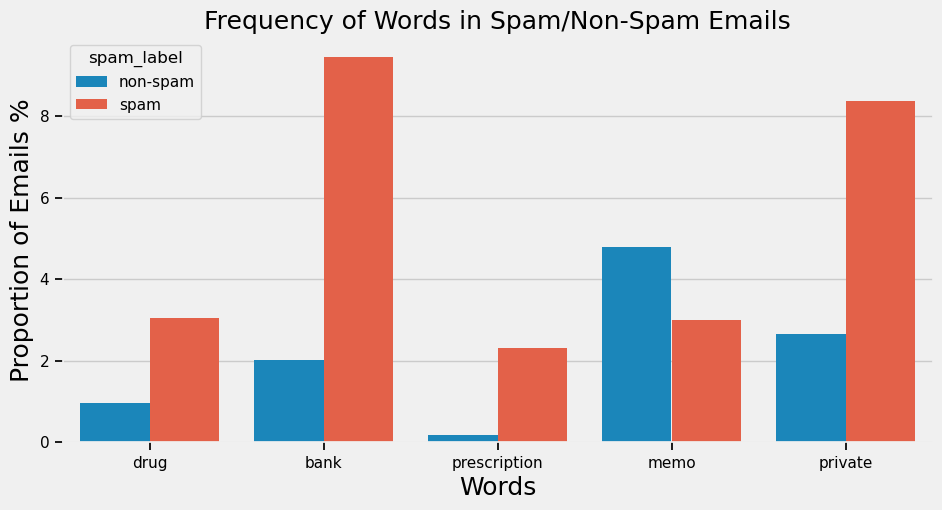

In [151]:
#An unpivoted dataframe is created to understand the total proportion of words
df_2i = pd.concat((word_detector(words, train['email']), 
                    train[['label']]), axis=1)
df_2i = df_2i.melt('label')
df_2i['value']=df_2i['value']*100

df_2i['spam_label'] = np.where(df_2i['label'] == 0, 'non-spam', 'spam')

#sns barplot is used to show the spam/non-spam proportion for the new words
plt.figure(figsize=(10, 5))
plt.title('Frequency of Words in Spam/Non-Spam Emails', fontsize=18)
ax = sns.barplot(x="variable", y='value', hue="spam_label", data=df_2i, ci=None)
ax.set_xlabel('Words', fontsize=18)
ax.set_ylabel('Proportion of Emails %', fontsize=18)
plt.show()

The words may not be sufficiently indicative of spam mails. From the plot, words like 'memo'have similar frequencies in both spam and non-spam emails while other words like drug, bank have slighly higher frequencies in spam emails but are still common in non-spam emails. These indicates that words alone might not be strong predictors of spam emails. The classifier may struggle to distinguish spam and non-spam emails based majorly on the presence or absence of these words. 

## Question 2j
Which of these two classifiers would you prefer for a `spam` filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics `accuracy`, `precision`, `recall`, and `false-alarm rate` we have computed so far.

In [153]:
print('Zero-predictor Accuracy {:.3f}'.format(zero_predictor_accuracy))
print('Zero-predictor Precision: {:.3f}'.format(zero_predictor_precision))
print('Zero-predictor Recall: {:.3f}'.format(zero_predictor_recall))
print('Zero-predictor False Alarm Rate: {:.3f}'.format(zero_predictor_far))

print('\nLogistic Model Accuracy {:.3f}'.format(lr_predictor_accuracy))
print('Logistic Model Precision: {:.3f}'.format(lr_predictor_precision))
print('Logistic Model Recall: {:.3f}'.format(lr_predictor_recall))
print('Logistic Model False Alarm Rate: {:.3f}'.format(lr_predictor_far))

Zero-predictor Accuracy 0.744
Zero-predictor Precision: 0.000
Zero-predictor Recall: 0.000
Zero-predictor False Alarm Rate: 0.000

Logistic Model Accuracy 0.757
Logistic Model Precision: 0.651
Logistic Model Recall: 0.112
Logistic Model False Alarm Rate: 0.021


In [ ]:
For a spam filter, I would prefer the Logistic Regression over the Zero Predictor because:

1. Logistic Regression has a higher recall compared to Zero Predictor (which has 0 recall). This means Logistic Regression is more effective at detecting actual spam emails.
2. Logistic Regression strives to balance precision and recall, whereas Zero Predictor has poor precision due to its simplistic approach.
3. Logistic Regression tends to have a lower false alarm rate compared to Zero Predictor, reducing the number of legitimate emails misclassified as spam.

## Build another Model
We'll be comparing models in the next section, so let's create another one using the words from Question 1c `['body', 'business', 'html', 'money', 'offer', 'please']`.

In [155]:
# Define words
words2 = ['body', 'business', 'html', 'money', 'offer', 'please']

# Get train data
X_train2 = word_detector(words2, train['email'])
y_train2 = train[['label']]

# Train model
model2 = LogisticRegression()
model2.fit(X_train2, y_train2)
y_true2 = y_train2.values.flatten()

# Print metrics
print('Accuracy {:.3f}'.format(accuracy(y_true2, model2.predict(X_train2))))
print('Precision: {:.3f}'.format(precision(y_true2, model2.predict(X_train2))))
print('Recall: {:.3f}'.format(recall(y_true2, model2.predict(X_train2))))
print('False Alarm Rate: {:.3f}'.format(false_alarm_rate(y_true2, model2.predict(X_train2))))

Accuracy 0.831
Precision: 0.729
Recall: 0.542
False Alarm Rate: 0.069


# 3. More Evaluation Metrics
Ok, so we have `precision` and `recall`, which appear to be more useful for evaluating our model than `accuracy` when we have imbalanced data. In some applications, we may only care about `precision` or `recall`, however, what if we care about both? In this case, the `F-beta` metric is useful. `F-beta` is the harmonic mean of `precision` and `recall` and is expressed by the following equation.

**$F_{\beta} = (1 + \beta^{2}) \frac{precision * recall}{\beta^{2} * precision + recall}$**

When choosing beta in your `F-beta` score, the more you care about `recall` over `precision` the higher `beta` should be. For example, with the `F1` score, we care equally about `recall` and `precision`, however, with the `F2` score, `recall` is twice as important and `precision`. 

More generally, with 0 < `beta` < 1, we care more about `precision`and with `beta` > 1, we care more about `recall`.

`F1` is the common form of `F-beta` and is widely used in many machine learning applications.

**$F_{1} = 2 \frac{precision * recall}{precision + recall}$**

## Question 3a
Create a function `f_beta` that computes the `F-beta` score we defined above. You may want to use some of the functions you have already created.

In [93]:
def f_beta(y_true, y_pred, beta):
    
    """
    Returns the F-beta score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels 
                                 np.array([0, 1, 0, 0, ..]).
        y_pred (1D numpy array): 1D array of predicted binary labels 
                                 np.array([1, 0, 0, 1, ..]).
        beta (float): The beta parameter for the F-beta metric.

    Returns:
        (float): The F-beta score.
    """
    print (f_beta)
    
     # f_beta is calculated using beta value, and the precision and recall functions from earlier
    f_beta_value = (1 + beta**2) * (precision(y_true,y_pred) * recall(y_true,y_pred)) / ( (beta**2)*precision(y_true,y_pred) + recall(y_true,y_pred))
    
    return f_beta_value

In [157]:
# Print results
print("Model 1\nwords = {}\nF1 Score: {:.3f}\n".format(words, f_beta(y_true, model.predict(X_train), beta=1)))
print("Model 2\nwords = {}\nF1 Score: {:.3f}".format(words2, f_beta(y_true2, model2.predict(X_train2), beta=1)))

<function f_beta at 0x0000023589A74900>
<function precision at 0x000002358A92DE40>
Model 1
words = ['drug', 'bank', 'prescription', 'memo', 'private']
F1 Score: 0.191

<function f_beta at 0x0000023589A74900>
<function precision at 0x000002358A92DE40>
Model 2
words = ['body', 'business', 'html', 'money', 'offer', 'please']
F1 Score: 0.622


Wow, thats a pretty significant difference in `F1` score between these two lists of words. 

### Probability Thresholds
You'll notice that when computing our metrics, we used the `model.predict()` method. For our model, it predicts a `0` (`not-spam`) or `1` (`spam`) for a given array of features. Let's check out the `model.predict()` method.

In [159]:
model.predict(X_train)

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

But, in your lecture, we learned that the output of the logistic model is a sigmoid function, which looks something like this.

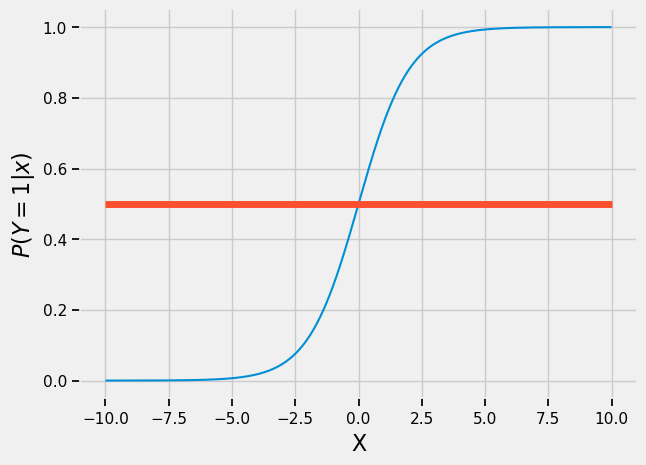

In [161]:
x_sigmoid = np.arange(-10, 10, 0.001)
y_sigmoid = sigmoid(x_sigmoid)
plt.plot(x_sigmoid, y_sigmoid, '-')
plt.plot([-10, 10], [0.5, 0.5], lw=5)
plt.xlabel('X', fontsize=16)
plt.ylabel(r'$P(Y = 1 | x)$', fontsize=16);

When you use the `.predict()` method, `scikit-learn` automatically applied a threshold of `0.5`. So in the plot above, everything less than **X = 0** is classified as **y = 0** and everything greater than **X = 0** is classified as **y = 1**. However, the threshold is something we can tune to our specific use case.

Take a minute and mess around with the interactive visualization below to gain an understanding for how the choice of your threshold can impact our metrics `accuracy`, `precision`, and `recall`. I have created a dummy dataset with one feature `the number of word counts for "body"` and a logistic model that predicts the probability of an email being `spam` given the `"body"` count.

In [101]:
threshold_prediction_plot()

interactive(children=(IntSlider(value=50, description='threshold'), Output()), _dom_classes=('widget-interact'…

Depending on what is important to us, we can set the threhold. For example, if we want a model with high precision, a threshold of `0.8` would work.

In [103]:
threshold_prediction_plot(0.8)

interactive(children=(IntSlider(value=80, description='threshold'), Output()), _dom_classes=('widget-interact'…

However, if recall is important, a threshold of `0.1` might work better. 

In [ ]:
threshold_prediction_plot(0.1)

So, how do we access these probabilities? We can use the `model.predict_proba()` method.

In [163]:
model.predict_proba(X_train)

array([[0.76423335, 0.23576665],
       [0.76423335, 0.23576665],
       [0.43326393, 0.56673607],
       ...,
       [0.76423335, 0.23576665],
       [0.76423335, 0.23576665],
       [0.76423335, 0.23576665]])

`model.predict_proba()` returns the probability of the sample for each class in the model, where classes are ordered as they are in `model.classes_`.

In [107]:
model.classes_

array([0, 1], dtype=int64)

So, the first column of `model.predict_proba(X_train)` is the probability of **0** `not-spam` and the second column is the probability of **1** `spam`. You notice that because there are only two classes, the sum of the first and second columns equals 1.

In [165]:
model.predict_proba(X_train)[0, 0] + model.predict_proba(X_train)[0, 1]

1.0

### Precision-Recall Curve
A useful visualization for understanding the trade-off between `precision` and `recall` is the `Precision-Recall (PR) Curve`. The `PR Curve` is a curve that combines `precision` and `recall` in a single visualization. For every threshold, you calculate `precision` and `recall` and plot it. The closer to the upper-right corner, the better your more is.

You can use this plot to make an educated decision when it comes to the `precision-recall` trade-off, where the higher the `recall` the lower the `precision`. Knowing at which `recall` your `precision` starts to fall fast can help you choose an optimal `threshold` and deliver a better model.

Spend some time playing with the interactive visualization below which displays the `PR Curve` for model 1 and model 2.

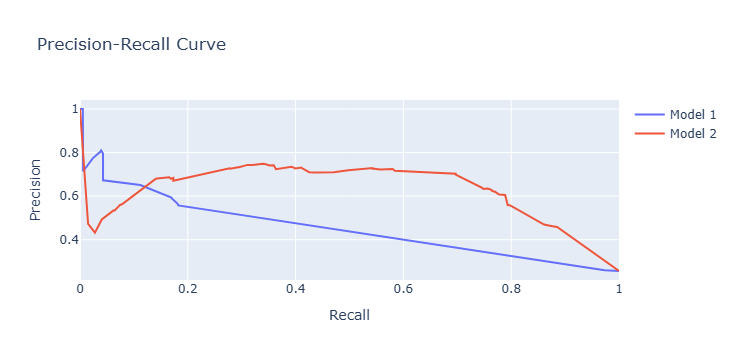

In [167]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import precision_recall_curve

# Initialize
init_notebook_mode(connected=True) 
fig = go.Figure()

# Model 1
y_scores = model.predict_proba(X_train)[:, 1]
model_precisions, model_recalls, model_thresholds = precision_recall_curve(y_true, y_scores)
model_thresholds = np.append(model_thresholds, [1.])
df1 = pd.DataFrame({'precision': model_precisions, 'recall': model_recalls, 'threshold': model_thresholds})
trace1 = go.Scatter(x=df1['recall'], y=df1['precision'], name='Model 1', mode='lines', hovertext=df1['threshold'],
                    hovertemplate='Precision=%{y}<br>Recall=%{x}<br>Threshold=%{hovertext}')

# Model 2
y_scores2 = model2.predict_proba(X_train2)[:, 1]
model_precisions2, model_recalls2, model_thresholds2 = precision_recall_curve(y_true2, y_scores2)
model_thresholds2 = np.append(model_thresholds2, [1.])
df2 = pd.DataFrame({'precision': model_precisions2, 'recall': model_recalls2, 'threshold': model_thresholds2})
trace2 = go.Scatter(x=df2['recall'], y=df2['precision'], name='Model 2', mode='lines', hovertext=df2['threshold'],
                    hovertemplate='Precision=%{y}<br>Recall=%{x}<br>Threshold=%{hovertext}')

layout = go.Layout(title='Precision-Recall Curve',
                   xaxis=dict(title='Recall'),
                   yaxis=dict(title='Precision'))

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.layout.update(hovermode='closest')

iplot(fig)

## Question 3b
Below is a function that computes the `F1` score given a threshold. When we calculated the `F1` score in Question 3a, we used a default threshold value of `0.5`.

In [173]:
def f1_threshold(y_true, y_pred_proba, threshold):
    
    """
    Returns the F-beta score.

    Parameters:
        y_true (1D numpy array): 1D array of true binary labels 
                                 np.array([0, 1, 0, 0, ..]).
        y_pred_proba (1D numpy array): 1D array of prediction probabilities 
                                       for the positive class
                                       (model.predict_proba(X)[:, 1])
                                       np.array([0.12, 0.56, 0.23, 0.89, ..]).
        threshold (float): The probability threshold, which is a number 
                           between 0 and 1.

    Returns:
        (float): The F1 score given a threshold.
    """
    
    # Calculate the binary predictions
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    return f_beta(y_true, y_pred, beta=1)

In [175]:
def count_true_positives(y_true, y_pred):
    return np.sum(np.logical_and(y_pred == 1, y_true == 1))

def count_false_positives(y_true, y_pred):
    return np.sum(np.logical_and(y_pred == 1, y_true == 0))

def count_false_negatives(y_true, y_pred):
    return np.sum(np.logical_and(y_pred == 0, y_true == 1))

def f1_threshold(y_true, y_pred_proba, threshold):
    """
    Calculate the F1 score given a threshold on predicted probabilities.

    Parameters:
        y_true (1D numpy array): True binary labels.
        y_pred_proba (1D numpy array): Predicted probabilities for the positive class.
        threshold (float): The probability threshold to convert probabilities to binary predictions.

    Returns:
        float: The F1 score.
    """
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate true positives, false positives, and false negatives
    tp = count_true_positives(y_true, y_pred)
    fp = count_false_positives(y_true, y_pred)
    fn = count_false_negatives(y_true, y_pred)

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # Calculate F1 score
    if precision + recall == 0:
        return 0.0
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score

def plot_f1_threshold(X, y, model):
    """
    Plots the F1 score against varying thresholds and displays the precision-recall curve.

    Parameters:
        X (array-like): Feature set for the model.
        y (1D numpy array): 1D array of true binary labels 
                            np.array([0, 1, 0, 0, ..]).
        model: A trained model with a predict_proba method to get probabilities for the positive class.
    """
    
    # Create threshold array
    thresholds = np.arange(0, 1, 0.01)
    
    # Compute F1 scores for each threshold
    f1_scores = np.array([f1_threshold(y.values.flatten(), model.predict_proba(X)[:, 1], threshold) 
                          for threshold in thresholds])
    
    # Get finite values
    finite_mask = np.isfinite(f1_scores)
    thresholds = thresholds[finite_mask]
    f1_scores = f1_scores[finite_mask]
    
    # Optimal values
    idx = np.argmax(f1_scores)
    f1_score = f1_scores[idx]
    optimal_threshold = thresholds[idx]

    # Plot F1 scores
    fig = plt.figure(figsize=(12, 4))
    fig.subplots_adjust(wspace=0.2, hspace=0)
    ax1 = plt.subplot2grid((1, 2), (0, 0))
    ax2 = plt.subplot2grid((1, 2), (0, 1))
    ax1.set_title('Optimal F1 score is {:.2f} for a threshold of {:.2f}.'.format(f1_score, optimal_threshold), fontsize=12)
    ax1.plot(thresholds, f1_scores, '.-')
    ax1.axvline(x=optimal_threshold, color='r', linestyle='--', label='Optimal F1 Threshold')
    ax1.legend()
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('F1 Score')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    
    # Get PR curve
    prc_precisions, prc_recalls, prc_thresholds = precision_recall_curve(y.values.flatten(), model.predict_proba(X)[:, 1])
    precision_opt = precision(y.values.flatten(), (model.predict_proba(X)[:, 1] >= optimal_threshold).astype(int))
    recall_opt = recall(y.values.flatten(), (model.predict_proba(X)[:, 1] >= optimal_threshold).astype(int))
    
    # Plot PR curve
    ax2.set_title('Optimal Precision is {:.2f} and Recall is {:.2f}.'.format(precision_opt, recall_opt), fontsize=12)
    ax2.plot(prc_recalls, prc_precisions, label='Precision-Recall Curve')
    ax2.plot(recall_opt, precision_opt, 'o', color='red', label='Optimal PR Point')
    ax2.legend()
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    
    # Show plots
    plt.show()

Above is a function called `plot_f1_threshold()`, which generates a plot of the `F1` score as a function of the threshold value and the `precision-recall` curve. Below, is an example if the function being used for model 1 with `X_train` and `y_train` .

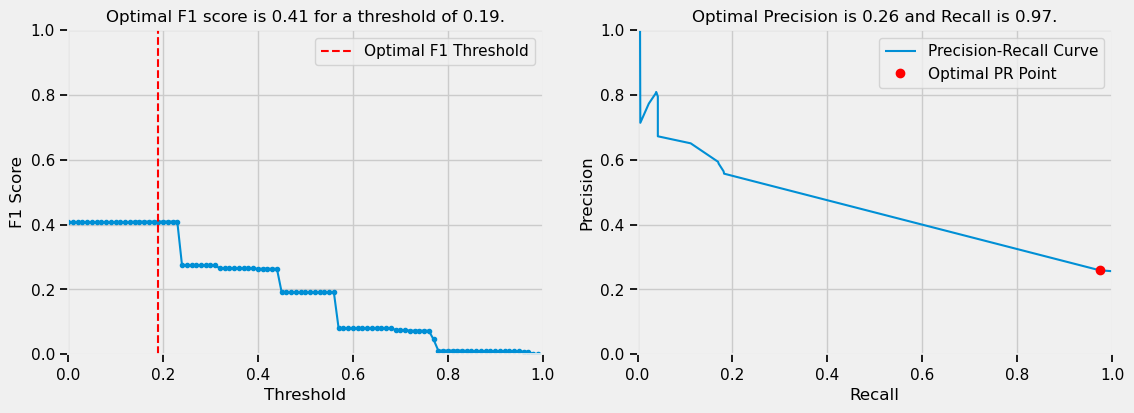

In [177]:
plot_f1_threshold(X_train, y_train, model)

For this question, you're task is to find the optimal `threshold`, `F1`, `precision` and `recall` for `model2`. You'll remember that `model2` uses features for these words `['body', 'business', 'html', 'money', 'offer', 'please']` (see variable `words2`).

First, which datset should you use to pick the optimal threshold (`train` or `val`), please explain your decision.

To pick the optimal threshold for model2, I would use the validation dataset (val), because;

1. Overfitting prevention: Using the training dataset (train) to determine the optimal threshold could lead to overfitting. The model may become too specialized to the training data and not generalize well to new, unseen data.
2. Unbiased evaluation: The validation dataset provides an unbiased evaluation of the model's performance. It simulates how the model will perform on new data, allowing us to estimate its true performance.

Next, use `plot_f1_threshold()` to find the optimal `threshold`, `F1`, `precision` and `recall` for `model2`.

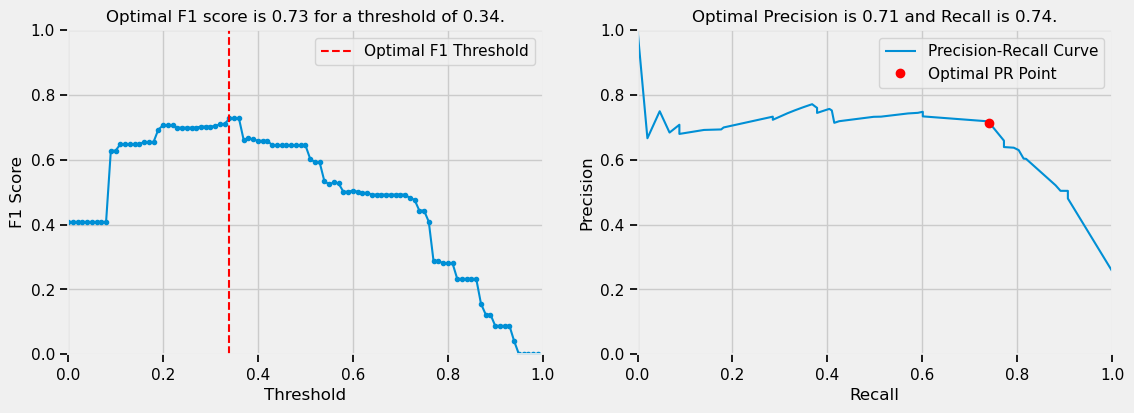

In [179]:
# The val data is split into X and y values
X_val = word_detector(words2, val['email'])
y_val = val[['label']]

# The plotting function is used to find the f1 threshold
plot_f1_threshold(X_val, y_val, model2)

Next, let's print `F1`, `precision` and `recall` scores using the default `0.5` `threshold`. 

In [181]:
print("Precision Score: {:.3f}".format(precision(y_val.values.flatten(), model2.predict(X_val))))
print("Recall Score: {:.3f}".format(recall(y_val.values.flatten(), model2.predict(X_val))))
print("F1 Score: {:.3f}".format(f_beta(y_val.values.flatten(), model2.predict(X_val), beta=1)))

Precision Score: 0.743
Recall Score: 0.570
<function f_beta at 0x0000023589A74900>
<function precision at 0x000002358A92DE40>
F1 Score: 0.645


Lastly, reflect on the difference between the optimal values and those using the default `threshold` of `0.5`. Would you use the default on your next project?

For the next project, the default value should not be used if using the same model. If the model changes (i.e. different classifiers) the process above must be repeated.